# Preprocessing Data

## Load Data

### Load packages

In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import anndata as ad
import scipy.io as scio
import episcanpy.api as epi
from matplotlib import pyplot as plt

### Specify required paths

In [2]:
GTF_PATH = '/mnt/workspace_stud/mbentse/homo_sapiens/homo_sapiens.104.mainChr.gtf'
INPUT_PATH = '/mnt/workspace_stud/mbentse/catlas_objects'
OUTPUT_PATH = '/mnt/workspace_stud/stud2/output'

### Define tissue sample and necessary files

In [3]:
# Example of reading mutlipe files into one matrix. Adjust for h5ad reading.
# See more at: https://github.com/theislab/scanpy/issues/267
TISSUE = 'colon_transverse'

filenames = ['colon_transverse_SM-A9HOW.h5ad',
'colon_transverse_SM-A9VP4.h5ad',
'colon_transverse_SM-ACCQ1.h5ad',
'colon_transverse_SM-BZ2ZS.h5ad',
'colon_transverse_SM-CSSDA.h5ad']

### Set up output folder structur

In [4]:
# create output folder structure
command = f"mkdir -p {OUTPUT_PATH}/{TISSUE}/{{preprocessing,wp3,wp4,wp6}}"
!$command
print(command)

mkdir -p /mnt/workspace_stud/stud2/output/colon_transverse/{preprocessing,wp3,wp4,wp6}


## Read and customize data

### Read and concatenate files into single Anndata object

In [5]:
adatas = [ad.read(f'{INPUT_PATH}/{filename}') for filename in filenames]
adata = adatas[0].concatenate(adatas[1:])

### Remove cells without features or empty features

In [6]:
epi.pp.filter_cells(adata, min_features=1)
epi.pp.filter_features(adata, min_cells=1)
adata.obs['log_nb_features'] = [np.log10(x) for x in adata.obs['nb_features']]
adata

AnnData object with n_obs × n_vars = 36845 × 1152578
    obs: 'batch', 'nb_features', 'log_nb_features'
    var: 'n_cells'

### Adjust peak names

In [7]:
names = []
for name in adata.var_names:
    names.append(name)

for i, n in enumerate(names):
    tmp = names[i].replace(':', '_')
    tmp = tmp.replace('-', '_')
    tmp = tmp.split('_')
    names[i] = '_'.join([tmp[0], tmp[-2], tmp[-1]])

adata.var_names = pd.Index(names)

### Save different layers

In [8]:
adata.raw = adata

In [9]:
epi.pp.binarize(adata)
adata.layers['binary'] = adata.X.copy()

## Filter Data

### Visualize feature distribution (Histogram)
These plots help 

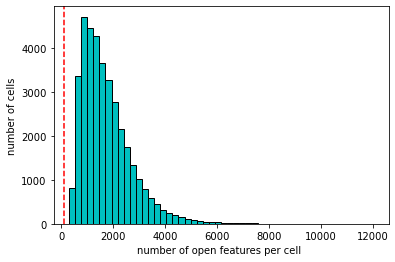

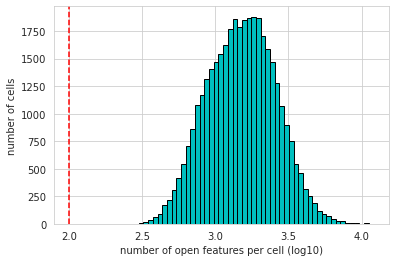

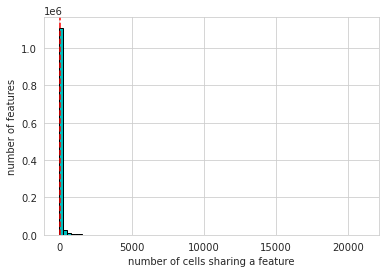

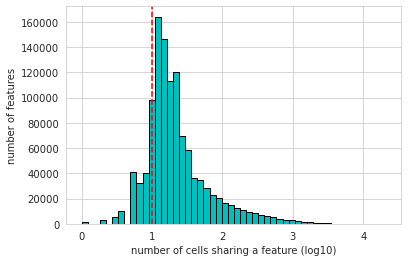

In [10]:
# show open features per cell
min_features = 100

epi.pp.coverage_cells(adata, binary=True, log=False, bins=50,
               threshold=min_features)
epi.pp.coverage_cells(adata, binary=True, log=10, bins=50,
               threshold=min_features)

# show numbers of cells sharing features
min_cells = 10

epi.pp.coverage_features(adata, binary=True, log=False, bins=50,
               threshold=min_cells)
epi.pp.coverage_features(adata, binary=True, log=10, bins=50,
               threshold=min_cells)

### Visualize feature distribution (Violin)

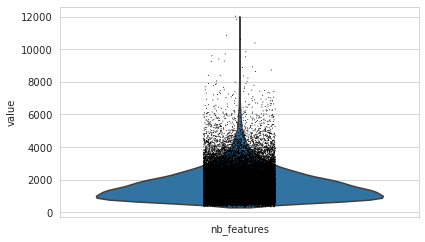

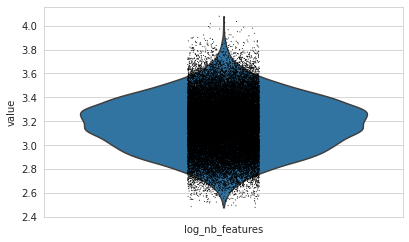

In [11]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

### Filter cells and features

In [12]:
epi.pp.filter_cells(adata, min_features=100)
epi.pp.filter_cells(adata, max_features=10000)

In [13]:
epi.pp.filter_features(adata, min_cells=10)
epi.pp.filter_features(adata, max_cells=150)

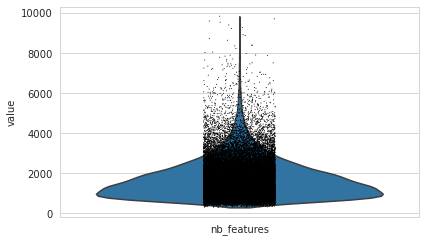

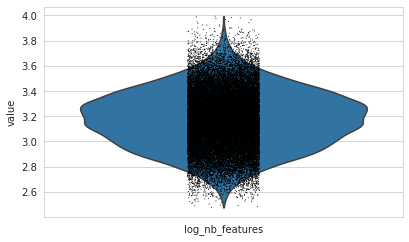

In [14]:
epi.pl.violin(adata, ['nb_features'])
epi.pl.violin(adata, ['log_nb_features'])

In [15]:
adata

AnnData object with n_obs × n_vars = 36840 × 898403
    obs: 'batch', 'nb_features', 'log_nb_features'
    var: 'n_cells', 'commonness'
    layers: 'binary'

## Cluster data

### Normalize remaining data

In [16]:
sc.pp.normalize_total(adata)
adata.layers['normalised'] = adata.X.copy()
epi.pp.log1p(adata)

### Calculate neighbors and clusters

In [17]:
sc.pp.pca(adata, n_comps=50, svd_solver='arpack', use_highly_variable=False)
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=50, method='umap', metric='euclidean')

### Cluster with louvain algorithm and show UMAP
Testing showed good results with:
- umap(min_dist = 0.1, spread = 2.0)
- louvain(resolution = 0.7, use_weights=False)

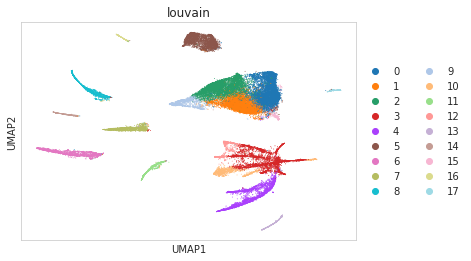

In [18]:
sc.tl.umap(adata, min_dist=0.1, spread=2.0)
sc.tl.louvain(adata, resolution=0.7, use_weights=False)

umap_plot = sc.pl.umap(adata, color=['louvain'], wspace=0.4, return_fig=True)
plt.savefig(f'{OUTPUT_PATH}/{TISSUE}/preprocessing/Cluster_{TISSUE}.png')
plt.show()

### Write files for subsequent processing

#### Filtering duplicated barcodes
Duplicates of the DNA part results in errors during further processing

In [19]:
barcodes = []
for barcode in adata.obs.index:
    temp = barcode.split("+")[1].split("-")[0]
    barcodes.append(temp)
adata.obs['barcode']=barcodes

In [37]:
deduplicated_adata = adata[adata.obs.index.isin(adata.obs['barcode'].drop_duplicates().index)]
print(f'Filtered: {len(adata.obs.index) - len(deduplicated_adata.obs.index)} duplicates')

Filtered: 937 duplicates


#### Writing files
Transforming '.obs' '.var' and '.X' of anndata into seperate files

In [21]:
output_wp4 = f'{OUTPUT_PATH}/{TISSUE}/wp4/{TISSUE}'
deduplicated_adata.var.to_csv(f'{output_wp4}_var.csv', sep='\t')
scio.mmwrite(f'{output_wp4}_X.mtx', deduplicated_adata.X)

with open(f'{output_wp4}_obs.csv', "w") as obs_file:
    obs_file.write("barcode\tcluster\n")
    for barcode in range(len(deduplicated_adata.obs.index)):
        line = f"{deduplicated_adata.obs.index[barcode]}\t{deduplicated_adata.obs['louvain'][barcode]}\n"
        obs_file.write(line)

## Gene Annotation

### Find genes
Use .gtf file to annotate peak locations to genes

In [22]:
epi.tl.find_genes(adata,
           gtf_file=GTF_PATH,
           key_added='gene_annotation',
           upstream=10000,
           feature_type='gene',
           annotation='havana',
           raw=False)

adata.var['gene_annotation']

chr1_9955_10355              DDX11L1
chr1_79215_79615          intergenic
chr1_181273_181673          DDX11L17
chr1_184281_184681        intergenic
chr1_185527_185927            WASH9P
                             ...    
chrY_21149986_21150386    intergenic
chrY_21176813_21177213    intergenic
chrY_21177347_21177747    intergenic
chrY_21185601_21186001    intergenic
chrY_56707025_56707425    intergenic
Name: gene_annotation, Length: 898403, dtype: object

### Filter unassigned / intergenic features
Peaks within or not in range of genes have no value for further identification

In [23]:
assigned_features = adata.var[adata.var['gene_annotation'] != "intergenic"]
assigned_features = assigned_features[assigned_features['gene_annotation'] != "unassigned"]
assigned_adata = adata[:, assigned_features.index]

assigned_adata

View of AnnData object with n_obs × n_vars = 36840 × 120401
    obs: 'batch', 'nb_features', 'log_nb_features', 'louvain', 'barcode'
    var: 'n_cells', 'commonness', 'gene_annotation'
    uns: 'log1p', 'pca', 'neighbors', 'umap', 'louvain', 'louvain_colors'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'binary', 'normalised'
    obsp: 'distances', 'connectivities'

### Replace peaks with gene names
Make new feature names unique and write them into raw

In [24]:
names = []

for n in assigned_adata.var['gene_annotation'].values:
    names.append(n)
    
assigned_adata.var_names = pd.Index(names)

In [25]:
assigned_adata.var_names_make_unique(join="_")
assigned_adata.raw = assigned_adata

### Rank genes

... storing 'barcode' as categorical
... storing 'gene_annotation' as categorical


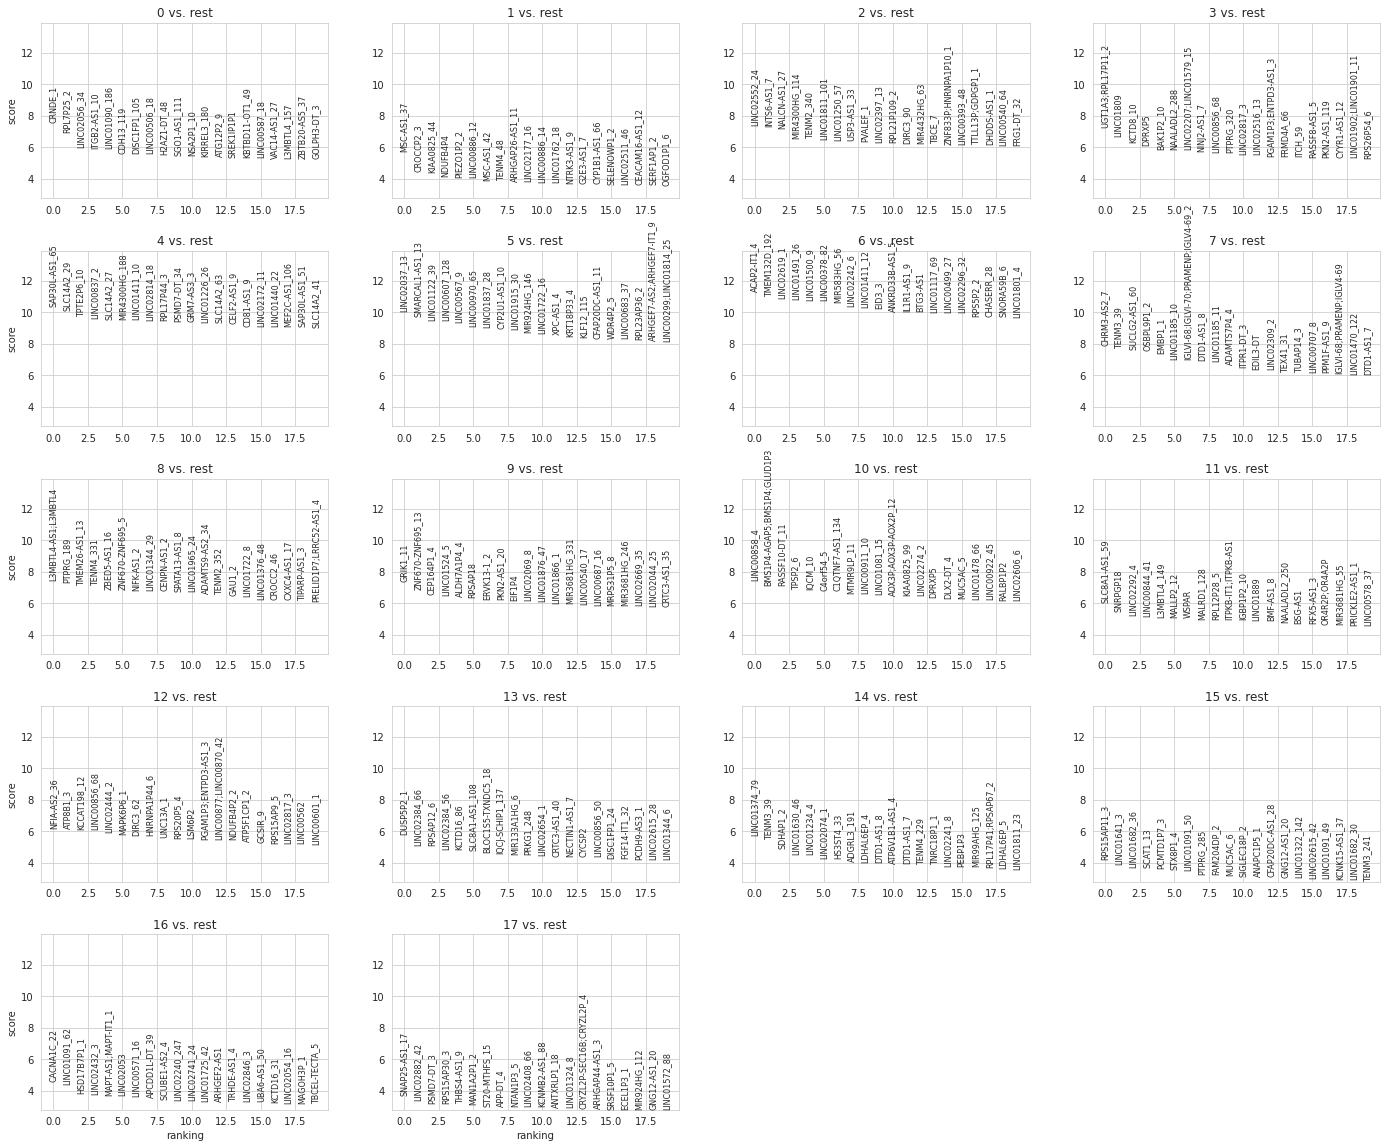

In [26]:
sc.tl.rank_genes_groups(assigned_adata, groupby='louvain', use_raw=False)
sc.tl.filter_rank_genes_groups(assigned_adata, groupby='louvain', use_raw=False)
sc.pl.rank_genes_groups(assigned_adata)

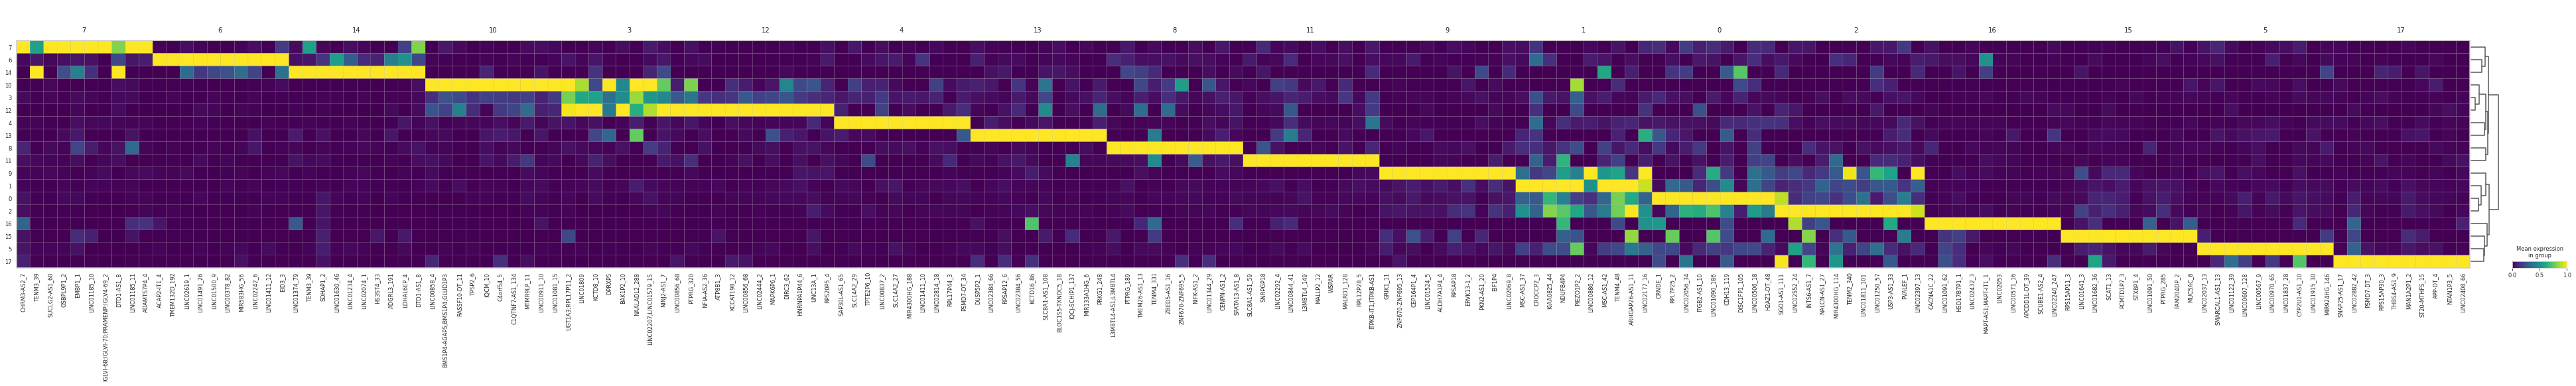

In [27]:
sc.pl.rank_genes_groups_matrixplot(assigned_adata, standard_scale='var', n_genes=10)

## Preparing for celltyp annotation

### Remove marker gene count
Before: gene_count

After: gene

In [28]:
result = assigned_adata.uns['rank_genes_groups']
for i, name_list in enumerate(result['names']):
    for j, name_string in enumerate(name_list):
        result['names'][i][j] = name_string.split('_')[0]

pd.DataFrame(result['names'])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,CRNDE,MSC-AS1,LINC02552,UGT1A3;RPL17P11,SAP30L-AS1,LINC02037,ACAP2-IT1,CHRM3-AS2,L3MBTL4-AS1;L3MBTL4,GRIK1,LINC00858,SLC8A1-AS1,NFIA-AS2,DUSP5P2,LINC01374,RPS15AP11,CACNA1C,SNAP25-AS1
1,RPL7P25,CROCCP2,INTS6-AS1,LINC01809,SLC14A2,SMARCAL1-AS1,TMEM132D,TENM3,PTPRG,ZNF670-ZNF695,BMS1P4-AGAP5;BMS1P4;GLUD1P3,SNRPGP18,ATP8B1,LINC02384,TENM3,LINC01641,LINC01091,LINC02882
2,LINC02056,KIAA0825,NALCN-AS1,KCTD8,TPTE2P6,LINC01122,LINC02619,SUCLG2-AS1,TMEM26-AS1,CEP164P1,RASSF10-DT,LINC02292,KCCAT198,RPSAP12,SDHAP1,LINC01682,HSD17B7P1,PSMD7-DT
3,ITGB2-AS1,NDUFB4P4,MIR4300HG,DPRXP5,LINC00837,LINC00607,LINC01491,OSBPL9P1,TENM4,LINC01524,TPSP2,LINC00844,LINC00856,LINC02384,LINC01630,SCAT1,LINC02432,RPS15AP30
4,LINC01090,PIEZO1P2,TENM2,BAK1P2,SLC14A2,LINC00567,LINC01500,EMBP1,ZBED5-AS1,ALDH7A1P4,IQCM,L3MBTL4,LINC02444,KCTD16,LINC01234,PCMTD1P7,MAPT-AS1;MAPT-IT1,THBS4-AS1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120396,MTMR9LP,CELF2-AS1,MTMR9LP,LINC01091,LINC01762,CYB5AP3,LINC00624,BTF3P9,HMGN2P21,LINC01764;UCA1,LINC01491,MIR583HG,PTOV1-AS1,UBA6-AS1,ATP8B1,LINC01491,LINC00607,ZNF833P;HNRNPA1P10
120397,HSD3BP2;GAPDHP74,LINC01500,DPH6-DT,LINC02235,MAP3K14-AS1,TMEM132D,LINC02328,LINC01764;UCA1,LINC01764;UCA1,LINC02295,UBA6-AS1,UBA6-AS1,UBA6-AS1,ZNF833P;HNRNPA1P10,MEF2C-AS1,ZNF833P;HNRNPA1P10,LINC00343,LHFPL6
120398,RPS3AP47,TEX21P,CYB5AP3,HMGN2P21,PHACTR1,HIVEP3,LINC01764;UCA1,RPL31P2,RPL31P2,LINC01491,ZNF833P;HNRNPA1P10,LINC00607,LINC00607,LHFPL6,ZNF833P;HNRNPA1P10,LINC00607,GLRXP3,LINC00343
120399,LINC00837,TMEM132D,LINC01764;UCA1,LINC02046,LINC02206,SLC8A1-AS1,MEF2C-AS1,ATP8B1,MEF2C-AS1,LHFPL6,LINC00607,EID3,EID3,LINC00607,LINC00607,EID3,EID3,GLRXP3


### Find first 100 unique marker genes per cluster

In [29]:
indices = {}
cutoff = 100

groups = result['names'].dtype.names
for group in groups:
    uniques = []
    indices[group] = []
    for i, value in enumerate(result['names'][group]):
        if value in uniques:
            continue
        uniques.append(value)
        indices[group].append(i)
        if len(uniques) == cutoff:
            break

## Cell Type Annotation with SCSA

### Creating csv for SCSA

In [30]:
output_sc_csv = f"{OUTPUT_PATH}/{TISSUE}/preprocessing/{TISSUE}.csv"

groups = result['names'].dtype.names
dat = pd.DataFrame({group + '_' + key[:1]: result[key][group][indices[group]] for group in groups for key in ['names', 'logfoldchanges','scores','pvals']})
dat.to_csv(output_sc_csv)

In [38]:
dat

,0_n,0_l,0_s,0_p,1_n,1_l,1_s,1_p,2_n,2_l,...,15_s,15_p,16_n,16_l,16_s,16_p,17_n,17_l,17_s,17_p
0,CRNDE,3.761877,7.562614,4.521552e-14,MSC-AS1,2.412640,5.736731,1.018053e-08,LINC02552,3.004278,...,4.213325,0.000033,CACNA1C,6.215211,4.554730,0.000008,SNAP25-AS1,6.813005,3.720425,0.000247
1,RPL7P25,2.656281,6.973250,3.400586e-12,CROCCP2,2.126209,4.450643,8.731670e-06,INTS6-AS1,3.157327,...,3.887750,0.000123,LINC01091,5.257252,4.373377,0.000017,LINC02882,3.977035,3.395471,0.000799
2,LINC02056,2.462107,6.016901,1.872207e-09,KIAA0825,1.699017,4.401347,1.095883e-05,NALCN-AS1,3.136530,...,3.728891,0.000228,HSD17B7P1,5.144165,3.851274,0.000144,PSMD7-DT,6.042099,3.207038,0.001520
3,ITGB2-AS1,2.638211,5.956127,2.718655e-09,NDUFB4P4,1.738102,4.155105,3.300172e-05,MIR4300HG,2.867422,...,3.676545,0.000277,LINC02432,6.677363,3.787550,0.000184,RPS15AP30,5.710546,3.199308,0.001559
4,LINC01090,2.139987,5.916840,3.444503e-09,PIEZO1P2,1.683364,4.115889,3.912334e-05,TENM2,2.809026,...,3.662573,0.000292,MAPT-AS1;MAPT-IT1,4.650083,3.715749,0.000242,THBS4-AS1,7.042691,3.163002,0.001759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,MMADHC-DT,1.849765,4.449028,8.764970e-06,HMGN1P33,1.500474,3.017344,2.561289e-03,MYO16-AS1,2.311200,...,2.101242,0.036405,TENM2,5.181356,2.513625,0.012482,LINC02343;GAMTP2;LINC00457,3.761990,2.155668,0.032083
96,MTCO2P12;MTCO3P12;MTATP8P1;MTATP6P1,1.685714,4.446673,8.862049e-06,SMIM10L2A;CROCCP1,1.245095,3.005844,2.659934e-03,RORA-AS1,2.158226,...,2.101160,0.036413,LINC02729,5.973312,2.506054,0.012747,PLEKHG1,3.904629,2.154651,0.032163
97,KCTD9P4,2.239260,4.445417,8.914468e-06,LINC01693,1.191384,3.004999,2.667005e-03,RAB33B-AS1,2.471744,...,2.092642,0.037173,NPAP1P4,5.635417,2.492939,0.013217,RPS28P8,5.457969,2.152746,0.032315
98,LINC01676,1.932994,4.443134,9.005926e-06,FKBP14-AS1,1.653051,3.002561,2.689188e-03,LINC00235,2.187588,...,2.087579,0.037631,NCMAP-DT,4.624494,2.490314,0.013313,USH2A-AS1,4.924774,2.140052,0.033338


### Create bash command
Paths needed for the SCSA.py script:
- **python3**: Executable of environment with pandas, numpy and scipy
- **scsa_loc**: Path to SCSA script itself
- **wholeDB_loc**: Path to SCSA-provided database
- **input_csv**: File with info about each marker gene in each cluster
- **results_file**: File to write SCSA results to
- **output_file**: Filte to write SCSA stdout info to

The command displays the celltype assignment

In [31]:
python3 = "/home/stud2/.conda/envs/datanew/bin/python3.9"
scsa_loc = f"/mnt/workspace_stud/stud2/SCSA/SCSA.py"
wholeDB_loc = f"/mnt/workspace_stud/stud2/SCSA/whole.db"
input_csv = output_sc_csv
results_file = f"{OUTPUT_PATH}/{TISSUE}/preprocessing/{TISSUE}_result"
output_file = f"{OUTPUT_PATH}/{TISSUE}/preprocessing/{TISSUE}_scsa.txt"

scsa_cmd = f"{python3} {scsa_loc} -d {wholeDB_loc} -i {input_csv} -s scanpy -E -f 1.5 -p 0.01 -o {results_file} -m txt"
scsa_cmd += f" > {output_file}; tail -{len(groups) + 1} {output_file}"
print(scsa_cmd)

/home/stud2/.conda/envs/datanew/bin/python3.9 /mnt/workspace_stud/stud2/SCSA/SCSA.py -d /mnt/workspace_stud/stud2/SCSA/whole.db -i /mnt/workspace_stud/stud2/output/colon_transverse/preprocessing/colon_transverse.csv -s scanpy -E -f 1.5 -p 0.01 -o /mnt/workspace_stud/stud2/output/colon_transverse/preprocessing/colon_transverse_result -m txt > /mnt/workspace_stud/stud2/output/colon_transverse/preprocessing/colon_transverse_scsa.txt; tail -19 /mnt/workspace_stud/stud2/output/colon_transverse/preprocessing/colon_transverse_scsa.txt


In [32]:
!$scsa_cmd

#Cluster Type Celltype Score Times
['0', '?', 'Granulocyte-monocyte progenitor|Meiotic prophase fetal germ cell', '1.5899898558618348|1.5899898558618348', 1.0]
['1', '?', 'Oogenesis phase fetal germ cell|Pyramidal cell', '0.7005936387905776|0.444609725403927', 1.57574969408078]
['10', 'Good', 'Pyramidal cell', 1.7655362050422887, 7.036976762023113]
['11', 'Good', 'Pyramidal cell', 1.6743658448992222, 4.5874017416408375]
['12', 'Good', 'Multilymphoid progenitor cell', 1.9219050272947669, 2.9104445965010597]
['13', 'Good', 'Natural killer T (NKT) cell', 1.4608500503700568, 8.676199487494591]
['14', 'Good', 'FGFR1HighNME5- epithelial cell', 1.6408102304259573, 5.884722480126648]
['15', '?', 'Airway secretory cell|Idiopathic pulmonary fibrosis cell', '0.5773502691896253|0.5773502691896253', 1.0]
['16', 'Good', 'Multilymphoid progenitor cell', 1.4938477498172396, 4.037483717348169]
['17', '?', 'Lake et al.Science.Ex8|Trophectoderm cell', 'nan|nan', nan]
['2', 'Good', 'Multilymphoid progenit

### View results

In [33]:
pd.read_csv(results_file, sep='\t')

,Cell Type,Z-score,Cluster
0,Granulocyte-monocyte progenitor,1.589990,0
1,Meiotic prophase fetal germ cell,1.589990,0
2,Oligodendrocyte,-0.247342,0
3,Multilymphoid progenitor cell,-0.312200,0
4,Plasmacytoid dendritic cell,-0.428708,0
...,...,...,...
99,Oocyte,-0.090325,9
100,Natural killer T (NKT) cell,-0.214988,9
101,SLC16A7+ cell,-0.214988,9
102,Oligodendrocyte,-0.908835,9


In [34]:
s = open(output_file).read().splitlines()
s

['Version V1.1 [2020/07/03]',
 'DB load: 47347 3 3 48257 37440',
 "Namespace(input='/mnt/workspace_stud/stud2/output/colon_transverse/preprocessing/colon_transverse.csv', output='/mnt/workspace_stud/stud2/output/colon_transverse/preprocessing/colon_transverse_result', db='/mnt/workspace_stud/stud2/SCSA/whole.db', source='scanpy', cluster='all', MarkerDB=None, foldchange=1.5, pvalue=0.01, weight=100.0, species='Human', tissue='All', outfmt='txt', celltype='normal', target='cellmarker', Gensymbol=True, norefdb=False, noprint=False, list_tissue=False)",
 'Version V1.1 [2020/07/03]',
 'DB load: 47347 3 3 48257 37440',
 'load markers: 45409',
 '############################## Cluster 0 ##############################',
 '',
 'Cell Num: 8',
 'Gene Num: 6',
 'Not Zero: 8',
 'Cluster 0 Gene number: 100',
 '------------------------------------------------------------',
 'Type                Cell Type           Score     Times',
 '------------------------------------------------------------',
 '? 

### Assign celltypes to clusters
Read results from SCSA output_file

If multiple Types where found, take the first

In [35]:
cluster_celltypes = {}

with open(output_file, 'r') as cluster_result:
    skip = True
    for line in cluster_result.read().splitlines():
        if line.startswith('#Cluster'):
            skip = False
            continue
        if skip:
            continue
            
        line = line.replace("[", "").replace("]", "").replace("'", "").split(",")
        cluster = line[0]
        celltype = line[2].split("|")[0].lstrip().replace(" ", "_")
        
        cluster_celltypes[cluster] = celltype

### Write out bed files
Create files with given scheme:

tissue.cluster_id.celltype.bed

In [39]:
for cluster in adata.obs['louvain'].unique():
    celltype = cluster_celltypes.get(cluster, [])
    
    cluster_adata = adata[adata.obs['louvain'] == cluster]
    epi.pp.filter_features(cluster_adata, min_cells=1)
    cluster_path = f'{OUTPUT_PATH}/{TISSUE}/wp6/{TISSUE}.{cluster}.{cluster_celltypes[cluster]}.bed'
    
    with open(cluster_path, 'w') as cl_output:
        for peak in cluster_adata.var.index:
            tmp = peak.replace('_', '\t')
            try:
                chromosome = int(tmp.split('\t')[0].replace('chr', ''))
            except:
                continue
            cl_output.write(f"{tmp}\n")

Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
Trying to set attribute `.var` of view, copying.
